# Section 3.5 Practical course material 1: The Wasserstein covariance distance estimation

This page contains simulations in Section 3.5 Practical course material 1

## Contents

    - Visualization of behavior of $x \mapsto x m_\mu(x)$
    - Classical versus random matrix improved covariance distance estimator
    - FUNCTIONS


## Visualization of behavior of $x \mapsto x m_\mu(x)$

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.linalg
pi = np.pi

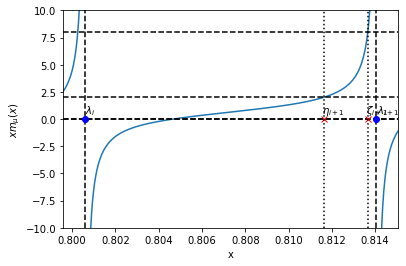

In [32]:
coeff = 3
p = 100*coeff
n1 = 300*coeff
n2 = 900*coeff

c1 = p/n1
c2 = p/n2

np.random.seed(928)
Z1 = np.random.randn(p,n1)
Z2 = np.random.randn(p,n2)

eig_C1 = [1,2,4]
eig_C2 = [1,3,5]
C1 = np.diag(np.concatenate([eig_C1[0]*np.ones(p//3),eig_C1[1]*np.ones(p//3),eig_C1[2]*np.ones(p//3)]))
C2 = np.diag(np.concatenate([eig_C2[0]*np.ones(p//3),eig_C2[1]*np.ones(p//3),eig_C2[2]*np.ones(p//3)]))

X1 = scipy.linalg.sqrtm(C1)@Z1
X2 = scipy.linalg.sqrtm(C2)@Z2

SCM1 = X1@(X1.T)/n1
SCM2 = X2@(X2.T)/n2

SCM = np.linalg.solve(SCM1,SCM2)
eigs_SCM = np.sort(np.linalg.eigh(SCM)[0])

m   = lambda x : np.sum(1/(eigs_SCM-x))/p
x_m = lambda x : x*m(x)

tol1 = 1e-3
index_eigs_SCM = 50
zoom_eigs_SCM  = np.linspace(eigs_SCM[index_eigs_SCM-1]-tol1,eigs_SCM[index_eigs_SCM]+tol1,1000)

tol2 = 1e-4
zoom_eigs_SCM[(zoom_eigs_SCM<=eigs_SCM[index_eigs_SCM-1]+tol2)*(zoom_eigs_SCM>=eigs_SCM[index_eigs_SCM-1]-tol2)]=np.nan
zoom_eigs_SCM[(zoom_eigs_SCM<=eigs_SCM[index_eigs_SCM]+tol2)*(zoom_eigs_SCM>=eigs_SCM[index_eigs_SCM]-tol2)]=np.nan

# numerical evaluation of eta and zeta
eta  = np.linalg.eigh(np.diag(eigs_SCM) - np.sqrt(eigs_SCM).reshape(p,1)@np.sqrt(eigs_SCM).reshape(1,p)/n1)[0]
eta  = eta[(eta<eigs_SCM[index_eigs_SCM])*(eta>eigs_SCM[index_eigs_SCM-1])]
zeta = np.linalg.eigh(np.diag(eigs_SCM) - np.sqrt(eigs_SCM).reshape(p,1)@np.sqrt(eigs_SCM).reshape(1,p)/n2)[0]
zeta = zeta[(zeta<eigs_SCM[index_eigs_SCM])*(zeta>eigs_SCM[index_eigs_SCM-1])]

plt.plot(zoom_eigs_SCM, [x_m(x) for x in zoom_eigs_SCM])
plt.axvline(x=eigs_SCM[index_eigs_SCM-1],ls='--',c='k')
plt.axvline(x=eigs_SCM[index_eigs_SCM],ls='--',c='k')
plt.axhline(y=0,ls='--',c='k')
plt.axhline(y=(1-c2)/c2,ls='--',c='k')
plt.axhline(y=(1-c1)/c1,ls='--',c='k')
plt.axhline(y=0,ls='--',c='k')
plt.gca().set_xlim([eigs_SCM[index_eigs_SCM-1]-tol1,eigs_SCM[index_eigs_SCM]+tol1])
plt.gca().set_ylim([-10,10])

plt.xlabel(r'x')
plt.ylabel(r'$x m_{\mu}(x)$')
plt.plot(eigs_SCM[index_eigs_SCM-1],0,'ob')
plt.text(eigs_SCM[index_eigs_SCM-1]+1e-5,.5,r'$\lambda_i$')
plt.plot(eigs_SCM[index_eigs_SCM],0,'ob')
plt.text(eigs_SCM[index_eigs_SCM]+1e-5,.5,r'$\lambda_{i+1}$')

plt.plot(eta, 0,'xr')
plt.plot(zeta, 0,'xr')
plt.text(eta-1e-4, .5,r'$\eta_{i+1}$')
plt.text(zeta-1e-4, .5,r'$\zeta_{i+1}$')
plt.axvline(x=eta,ls=':',c='k')
plt.axvline(x=zeta,ls=':',c='k')
_ = plt.show()

## Classical versus random matrix improved covariance distance estimator

In [115]:
p_loop = [2**(i+1) for i in range(9)]
n1 = 1024
n2 = 512

np.random.seed(928)
nb_average_loop = 1
store_output = [] # [population distance, RMT estimator, classical estimator]

for p in p_loop:

    C1 = scipy.linalg.toeplitz([.2**i for i in range(p)])
    C2 = scipy.linalg.toeplitz([.4**i for i in range(p)])
    
    C1_half = scipy.linalg.sqrtm(C1)
    C2_half = scipy.linalg.sqrtm(C2)
    C1C2_half = scipy.linalg.sqrtm( C1_half@C2@C1_half )
    
    tmp = np.zeros(3)
    for j in range(nb_average_loop):
        X1 = C1_half@np.random.randn(p,n1)
        X2 = C2_half@np.random.randn(p,n2)

        RMTDistEst,ClassDistEst = RMTWassDist(X1,X2)
        tmp += np.array([np.trace(C1 + C2 - 2*C1C2_half)/p,RMTDistEst,ClassDistEst])/nb_average_loop

    store_output.append(tmp)

print('Performance of different estimators:')
for i in range(len(p_loop)):
    print("{}\t{}\t{}\t{}".format(p_loop[i],store_output[i][0],store_output[i][1],store_output[i][2]))

Performance of different estimators:
2	0.01103153729087758	0.011381757151153415	0.012778234273914002
4	0.01750717844739269	0.014450066708239895	0.017204215542470536
8	0.02081924763165882	0.015877136088888966	0.021175338274475486
16	0.022475896600756218	0.019148285159616307	0.029801390026295005
32	0.023304221170649043	0.026164700442531386	0.04736612485315406
64	0.02371838345559516	0.02402301337806101	0.0665768080022584
128	0.023925464598065133	0.02264929988273856	0.10773172610611592
256	0.024029005169301777	0.02610212649441679	0.19696111652931303
512	0.024080775454917852	0.026801103362922518	0.37839839754303717


## FUNCTIONS

Code translated from https://github.com/maliktiomoko/RMTWasserstein

In [116]:
def RMTWassDist(X1,X2):
#Function that compute the Wasserstein distance between Gaussian centered
#distribution based on the article Random  Matrix-Improved  Estimation  of  the  Wasserstein  Distance
#between  two  Centered  Gaussian  Distribution (Malik TIOMOKO & Romain COUILLET)
#Input samples from the first class X1 of dimension p*n1 and the
#samples from the second class X2 of size p*n2

    p=np.size(X1,0)
    n1=np.size(X1,1)
    n2=np.size(X2,1)
    c1=p/n1
    c2=p/n2

    #Sample covariance estimate
    hatC1=X1@X1.T/n1
    hatC2=X2@X2.T/n2
    lambda_=np.sort(np.real(np.linalg.eig(hatC1@hatC2)[0]))

    m= lambda z : np.mean(1/(lambda_-z))
    phi= lambda z : z/(1-c1-c1*z*m(z))
    psi= lambda z : 1-c2-c2*z*m(z)
    f= lambda z : np.sqrt(z)

    eta =np.sort(np.linalg.eigh(np.diag(lambda_)-(1/n1)*np.sqrt(lambda_).reshape(p,1)@np.sqrt(lambda_).reshape(1,p))[0])
    zeta=np.sort(np.linalg.eigh(np.diag(lambda_)-(1/n2)*np.sqrt(lambda_).reshape(p,1)@np.sqrt(lambda_).reshape(1,p))[0])
    
    # Distinguish the case n1=n2 vesus n1!=n2
    if n1==n2:
        RMTDistEst=(1/p)*np.trace(hatC1+hatC2)-2*(np.sum(np.sqrt(lambda_))-np.sum(np.sqrt(zeta)))*(2*n1/p)
    else:
        # Distinguish the case where n1<n2 to the case where n1>n2
        if eta[0]<zeta[0]:
            my_eta=zeta
            my_zeta=eta
        else:
            my_zeta=zeta
            my_eta=eta
        
        other= lambda z : 2*np.sum(1/(z-zeta))-2*np.sum(1/(z-lambda_))

        integrand_real= lambda z : 1/(2*pi)*2*f(-(phi(z)/psi(z)))*other(z)*(psi(z)/c2)

        # Computing the second term (real_integral)
        real_integral=0
        for i in range(len(my_zeta)):
            #xs=np.linspace(my_zeta[i],my_eta[i],1000)
            #xs=xs[1:-1]
            
            real_integral+= scipy.integrate.quad(integrand_real,my_zeta[i],my_eta[i],full_output=1)[0] #np.trapz([integrand_real(z) for z in xs],x=xs)

        # Computing the first term (pole in lambda)
        pole=2*(np.sqrt(c2/c1))*np.sum(np.sqrt(lambda_))/c2
        esty=pole+real_integral

        RMTDistEst=(1/p)*np.trace(hatC1+hatC2)-2*esty



    #Classical estimate
    ClassDistEst=(1/p)*(np.trace(hatC1+hatC2)-2*np.trace(scipy.linalg.sqrtm(scipy.linalg.sqrtm(hatC1)@hatC2@scipy.linalg.sqrtm(hatC1))))
                   
    return RMTDistEst,ClassDistEst                   